In [170]:
import matplotlib, time
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from numpy import pi, sqrt, ceil, array, sin, cos, tan, arctan, tanh, log, exp
from scipy import optimize
from math import erf
from qutip import (Qobj, tensor, basis, fock, ket, bra, num, qeye, destroy, fidelity, expect, ket2dm, mesolve, 
                   identity, sigmax, sigmay, sigmaz, Options, mcsolve
                  )
from qutip.visualization import plot_fock_distribution, matrix_histogram
                  
font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
matplotlib.rcParams['xtick.direction'] = 'in'  
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(suppress=True)
from qutip.visualization import hinton
import math as math
# important settings to improve ODE solver
options = Options()
options.num_cpus=24
options.atol = 1e-12
options.rtol = 1e-10
options.order = 40
options.nsteps = 20000
import cython
import random

In [2]:
def Rge(phi, theta):
    mat = [[cos(theta/2), -exp(-1j*phi)*sin(theta/2), 0], 
           [exp(1j*phi)*sin(theta/2), cos(theta/2), 0], 
           [0, 0, 1]]
    return Qobj(mat)
def Ref(phi, theta):
    mat = [[1, 0, 0],
           [0, cos(theta/2), -exp(-1j*phi)*sin(theta/2)], 
           [0, exp(1j*phi)*sin(theta/2), cos(theta/2)]]
    return Qobj(mat)
def step(x):
    return 1 * (x > 0)
def ZZ(ge, ef):
    op = [[1, 0, 0,0], [0, np.exp(1j*ge/180*pi), 0,0], [0, 0, np.exp(1j*(ge+ef)/180*pi),0],[0,0,0,1]]
    op = Qobj(op)
    return op

In [3]:
def show_plot_rho(rho_MLE, rho_id=None, title1="Re[$\\rho_{MLE}$]", title2="Im[$\\rho_{MLE}$]", title3="Re[$\\rho_{ideal}$]", title4="Im[$\\rho_{ideal}$]"):
    if rho_id is None:
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
    else:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(223)
        ax4 = fig.add_subplot(224)
    
    labels = ["gg", "ge", "gf", "gh", "eg", "ee", "ef", "eh", "fg", "fe", "ff", "fh", "hg", "he", "hf", "hh"]
    hinton(np.round(np.real(rho_MLE),decimals=10), xlabels=labels, ylabels=labels, ax=ax1)
    hinton(np.round(np.imag(rho_MLE),decimals=10), xlabels=labels, ylabels=labels, ax=ax2)
    if rho_id is not None:
        hinton(np.round(np.real(rho_id),decimals=10), xlabels=labels, ylabels=labels, ax=ax3)
        hinton(np.round(np.imag(rho_id),decimals=10), xlabels=labels, ylabels=labels, ax=ax4)
    
    ax1.set_title(title1)
    ax2.set_title(title2)
    if rho_id is not None:
        ax3.set_title(title3)
        ax4.set_title(title4)

In [4]:
def fitgeneral(xdata, ydata, fitfunc, fitparams, domain=None, showfit=False, showstartfit=False, showdata=True,
               label="", mark_data='bo', mark_fit='r-'):
    """Uses optimize.leastsq to fit xdata ,ydata using fitfunc and adjusting fit params"""

    # sort data
    order = np.argsort(xdata)
    xdata = xdata[order]
    ydata = ydata[order]

    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
#    print 'minimum', np.min(fitdatay)
#    ymin=np.min(fitdatay)
    errfunc = lambda p, x, y: (fitfunc(p,x) - y) #there shouldn't be **2 # Distance to the target function
    startparams=fitparams # Initial guess for the parameters
    bestfitparams, success = optimize.leastsq(errfunc, startparams[:], args=(fitdatax,fitdatay))
    if showfit:
        if showdata:
            plt.plot(fitdatax,fitdatay,mark_data,label=label+" data")
        if showstartfit:
            plt.plot(fitdatax,fitfunc(startparams,fitdatax),label=label+" startfit")
        plt.plot(fitdatax,fitfunc(bestfitparams,fitdatax),mark_fit,label=label+" fit")
        if label!='': plt.legend()
        err=math.fsum(errfunc(bestfitparams,fitdatax,fitdatay))
        #print 'the best fit has an RMS of {0}'.format(err)
#    plt.t
#    plt.figtext()    
    return bestfitparams

def fitsin(xdata,ydata,fitparams=None,domain=None,showfit=False,showstartfit=False,label=""):
    """Fits sin wave of form: p[0]*np.sin(2.*pi*p[1]*x+p[2]*pi/180.)+p[3]"""
    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
    if fitparams is None:    
        FFT=scipy.fft(fitdatay)
        fft_freqs=scipy.fftpack.fftfreq(len(fitdatay),fitdatax[1]-fitdatax[0])
        max_ind=np.argmax(abs(FFT[4:len(fitdatay)/2.]))+4
        fft_val=FFT[max_ind]
        
        fitparams=[0,0,0,0]
        fitparams[3]=np.mean(fitdatay)
        fitparams[0]=(max(fitdatay)-min(fitdatay))/2.#2*abs(fft_val)/len(fitdatay)
        fitparams[1]=fft_freqs[max_ind]
        fitparams[2]=(cmath.phase(fft_val)-np.pi/2.)*180./np.pi
        #fitparams[3]=(max(fitdatax)-min(fitdatax))
        #fitparams[5]=fitdatax[0]
        
    sin2=lambda p,x: p[0]*np.cos(2.*np.pi*p[1]*x+p[2]*np.pi/180.)+p[3]
    #print "fitparams: ",fitparams
    p1 = fitgeneral(fitdatax, fitdatay, sin2, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                    label=label)
    return p1  


# Check f0-g1 sideband 

In [21]:
N_q = 4
N_r = 3
w_q = 3568.1751638611518 * 2 * np.pi
w_r = 4984.026194477733 * 2 * np.pi
alpha = -142.6213694550852 * 2 * np.pi
sigma = 0.005
tlength = 1.5+sigma*6

g = 46.540393946777 * 2 * np.pi   # for ZZ=280kHz * 2*pi

eps = 150 * 2 * np.pi

a_q = tensor(destroy(N_q), qeye(N_r))
a_r = tensor(qeye(N_q), destroy(N_r))

H0 = w_q*a_q.dag()*a_q+w_r*a_r.dag()*a_r+alpha/2*a_q.dag()*a_q.dag()*a_q*a_q+g*(a_q.dag()-a_q)*(a_r.dag()-a_r)
Hx1 = eps*(a_q.dag()+a_q)

def fff(t, args):
    return (step(args['start']+2*args['sigma']-t)*exp(-(t-args['start']-2*args['sigma'])**2/sigma/sigma/2)+ \
            step(t-args['stop']+2*args['sigma'])*exp(-(t-args['stop']+2*args['sigma'])**2/sigma/sigma/2)+ \
           step(t-args['start']-2*args['sigma'])*step(args['stop']-2*args['sigma']-t))*cos(args['wx1']*t+args['phase'])
Ht = [H0, [Hx1, fff]]

psi0 = tensor(basis(N_q, 2),basis(N_r,0)) # Initial state
psi0 = psi0.unit()
tlist = np.linspace(0, tlength, 1001)

c_ops = []

wx1 = abs(w_q*2+alpha-w_r)-6.2*2*np.pi

print('Running mesolve...')
args = {'wx1': wx1, 'phase':0,'sigma':sigma, 'start':0, 'stop':tlength}
output = mesolve(Ht, psi0, tlist, c_ops, [], args, options=options)


Running mesolve...


0.998008487129731


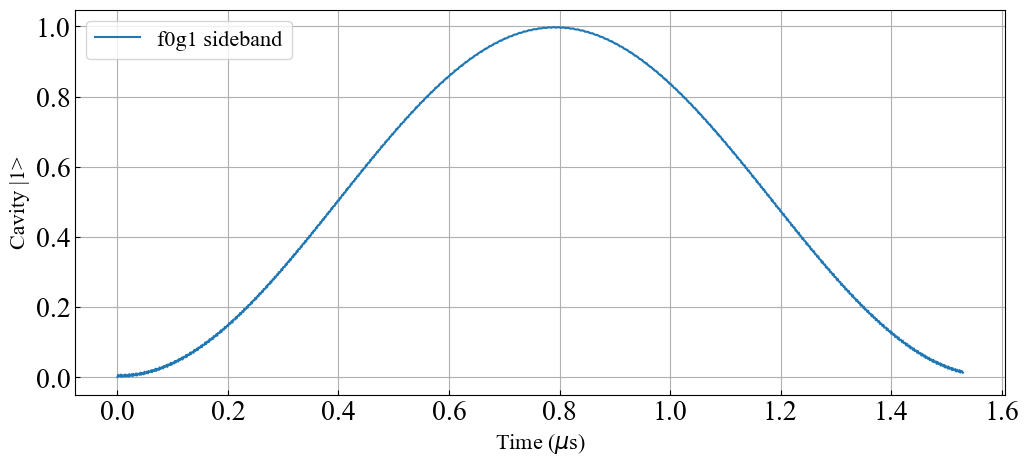

In [22]:
c_photon = tensor(qeye(N_q), ket("1",N_r)*bra("1",N_r))
result = []
for ii in output.states:
    result.append(expect(c_photon, ii))
print(max(result))

fig, ax = plt.subplots(1, 1, figsize=(12,5))

ax.plot(tlist, result, label='f0g1 sideband')
ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel('Cavity |1>')
ax.tick_params(labelsize=20)
plt.legend(fontsize=16, loc=2)
plt.grid()

# Check f0g1, rotating frame for simplicity

In [78]:
N_q = 4
N_r = 3
w_q = 3568.1751638611518 * 2 * np.pi
w_r = 4984.026194477733 * 2 * np.pi
alpha = -142.6213694550852 * 2 * np.pi
sigma = 0.005
tlength = 2
zz = -0.28 * 2 * np.pi

Tt = 0.615286689634651+0.005*6

J = 1/Tt/2*2*np.pi/np.sqrt(2)/2  # for ZZ=280kHz * 2*pi


a_q = tensor(destroy(N_q), qeye(N_r))
a_r = tensor(qeye(N_q), destroy(N_r))

Hzz = zz*a_q.dag()*a_q*a_r.dag()*a_r
Hx1 = J*(a_q.dag()*a_q.dag()*a_r+a_q*a_q*a_r.dag())

Ht = [Hzz+Hx1]

psi0 = tensor(basis(N_q, 2),basis(N_r,0)) # Initial state
psi0 = psi0.unit()
tlist = np.linspace(0, tlength, 1001)

c_ops = []


print('Running mesolve...')
args = {}
output = mesolve(Ht, psi0, tlist, c_ops, [], args, options=options)

Running mesolve...


0.9999998839736932


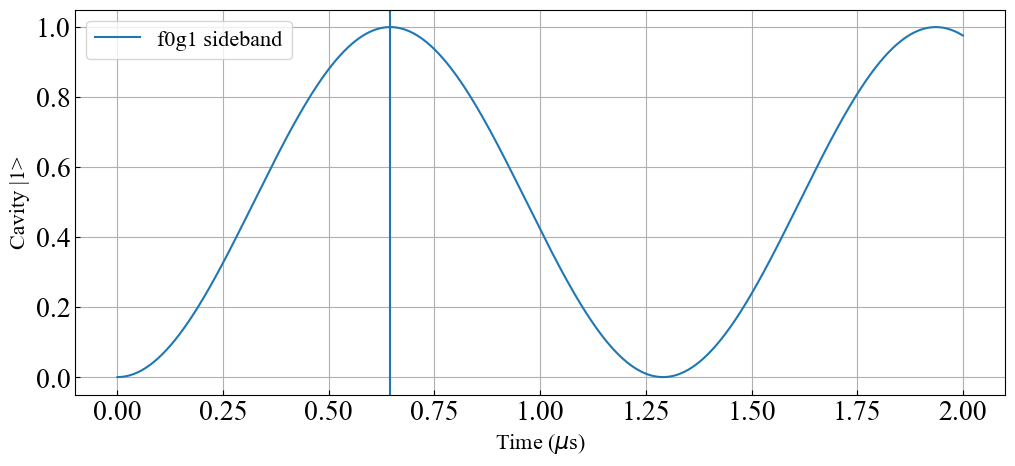

In [79]:
c_photon = tensor(qeye(N_q), ket("1",N_r)*bra("1",N_r))
result = []
for ii in output.states:
    result.append(expect(c_photon, ii))
print(max(result))

fig, ax = plt.subplots(1, 1, figsize=(12,5))

ax.plot(tlist, result, label='f0g1 sideband')
ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel('Cavity |1>')
ax.tick_params(labelsize=20)
plt.axvline(Tt)
plt.legend(fontsize=16, loc=2)
plt.grid()

# SWAP between two resonator modes

In [89]:
N_r1 = 3
N_r2 = 3
w_r1 = 5200 * 2 * np.pi
w_2 = 4984.026194477733 * 2 * np.pi
sigma = 0.005
tlength = 2
zz = -0.0 * 2 * np.pi

Tt = 0.919488+0.005*6

J = 1/Tt/2*2*np.pi/2  # for ZZ=280kHz * 2*pi


a_r1 = tensor(destroy(N_r1), qeye(N_r2))
a_r2 = tensor(qeye(N_r1), destroy(N_r2))

Hzz = zz*a_r1.dag()*a_r1*a_r2.dag()*a_r2
Hx1 = J*(a_r1.dag()*a_r2+a_r1*a_r2.dag())

Ht = [Hzz+Hx1]

psi0 = tensor(basis(N_r1, 1),basis(N_r2,0)) # Initial state
psi0 = psi0.unit()
tlist = np.linspace(0, tlength, 1001)

c_ops = []


print('Running mesolve...')
args = {}
output = mesolve(Ht, psi0, tlist, c_ops, [], args, options=options)

Running mesolve...


0.9999992825368312


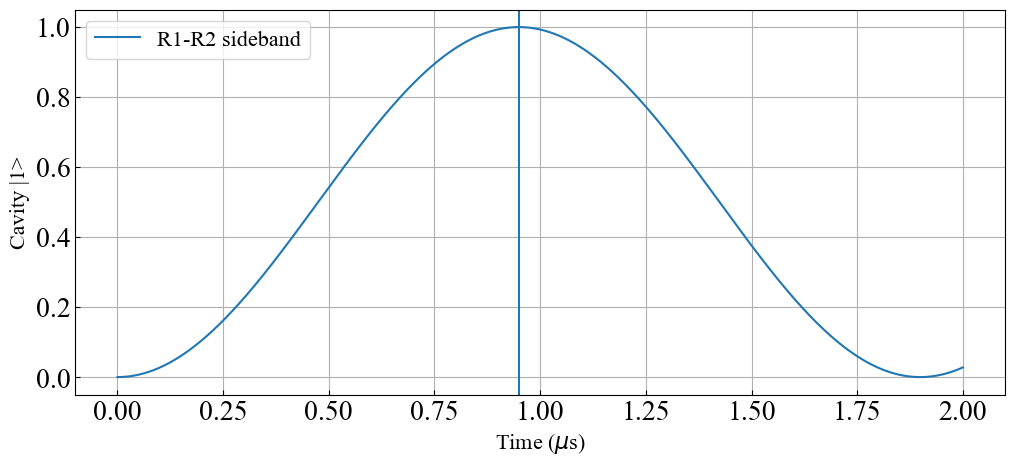

In [90]:
c_photon = tensor(qeye(N_r1), ket("1",N_r2)*bra("1",N_r2))
result = []
for ii in output.states:
    result.append(expect(c_photon, ii))
print(max(result))

fig, ax = plt.subplots(1, 1, figsize=(12,5))

ax.plot(tlist, result, label='R1-R2 sideband')
ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel('Cavity |1>')
ax.tick_params(labelsize=20)
plt.axvline(Tt)
plt.legend(fontsize=16, loc=2)
plt.grid()

# check qubit rotation

In [100]:
N_q = 4

w_q = 3568.1751638611518 * 2 * np.pi
alpha = -142.6213694550852 * 2 * np.pi
sigma = 0.005
tlength = 2
zz = -0.28 * 2 * np.pi

Tt = 0.615286689634651+0.005*6

J = 1/Tt/2*2*np.pi/2  # for ZZ=280kHz * 2*pi


a_q = destroy(N_q)
op_ge = ket("1", N_q)*bra("0", N_q)+ket("0", N_q)*bra("1", N_q)
op_ef = ket("1", N_q)*bra("2", N_q)+ket("2", N_q)*bra("1", N_q)


Hx1 = J*op_ef

Ht = [Hx1]

psi0 = basis(N_q, 2) # Initial state
psi0 = psi0.unit()
tlist = np.linspace(0, tlength, 1001)

c_ops = []


print('Running mesolve...')
args = {}
output = mesolve(Ht, psi0, tlist, c_ops, [], args, options=options)

Running mesolve...


0.9999998839727615


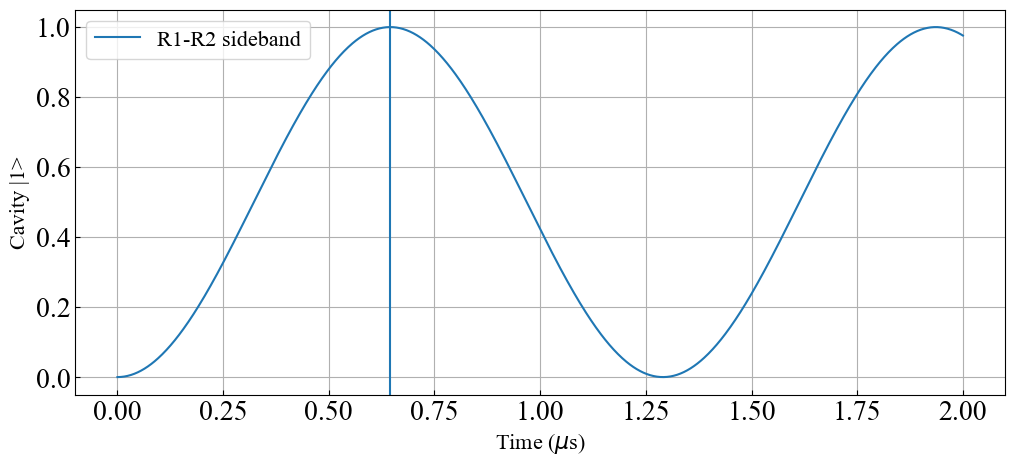

In [101]:
c_photon = ket("1",N_q)*bra("1",N_q)
result = []
for ii in output.states:
    result.append(expect(c_photon, ii))
print(max(result))

fig, ax = plt.subplots(1, 1, figsize=(12,5))

ax.plot(tlist, result, label='R1-R2 sideband')
ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel('Cavity |1>')
ax.tick_params(labelsize=20)
plt.axvline(Tt)
plt.legend(fontsize=16, loc=2)
plt.grid()

# The full system (smallest model) Q-M-S1-S2

In [451]:
def QMSS_system(tlist, t0, psi0, driving_param, device):
    # curoff photon number
    N_q, N_m, N_s = device['N_q'], device['N_m'], device['N_s']
    # wq, wm, ws1, ws2 = device['wq'], device['wm'], device['ws1'], device['ws2']
    # alpha = device['alpha']

    zz_qm, zz_ms1, zz_ms2, zz_s12 = device['zz_qm'], device['zz_ms1'], device['zz_ms2'], device['zz_s12']

    # driving is always constant pulses

    A_ge, A_ge_y, A_ef = driving_param['A_ge'], driving_param['A_ge_y'], driving_param['A_ef']
    A_f0g1 = driving_param['A_f0g1']
    A_m1s1, A_m1s2 = driving_param['A_m1s1'], driving_param['A_m1s2']

    # coherence
    T1_q, T1_m, T1_s1, T1_s2 = device['T1_q'],device['T1_m'],device['T1_s1'],device['T1_s2']
    T2_q, T2_m, T2_s1, T2_s2 = device['T2_q'],device['T2_m'],device['T2_s1'],device['T2_s2']

    ## define driving operators
    a_q = tensor(destroy(N_q),qeye(N_m),qeye(N_s),qeye(N_s))
    a_m = tensor(qeye(N_q),destroy(N_m),qeye(N_s),qeye(N_s)) 
    a_s1 = tensor(qeye(N_q),qeye(N_m),destroy(N_s),qeye(N_s))
    a_s2 = tensor(qeye(N_q),qeye(N_m),qeye(N_s),destroy(N_s))

    op_ge = tensor(ket("1", N_q)*bra("0", N_q)+ket("0", N_q)*bra("1", N_q),qeye(N_m),qeye(N_s),qeye(N_s))  #coeff is 1/pi_lenght/2/pi
    op_ge_y = tensor(1j*ket("1", N_q)*bra("0", N_q)-1j*ket("0", N_q)*bra("1", N_q),qeye(N_m),qeye(N_s),qeye(N_s))  #coeff is 1/pi_lenght/2/pi
    op_ef = tensor(ket("1", N_q)*bra("2", N_q)+ket("2", N_q)*bra("1", N_q),qeye(N_m),qeye(N_s),qeye(N_s))  #coeff is 1/pi_lenght/2/pi
    op_f0g1 = a_q.dag()*a_q.dag()*a_m+a_q*a_q*a_m.dag()   #coeff is 1/pi_lenght/2/pi/sqrt(2)
    op_m1s1 = a_m.dag()*a_s1+a_m*a_s1.dag()  # coeff is 1/pi_lenght/2/pi
    op_m1s2 = a_m.dag()*a_s2+a_m*a_s2.dag()   #coeff is 1/pi_lenght/2/pi

    # system static hamiltonan (ZZ part)
    H_0 = zz_qm*a_q.dag()*a_q*a_m.dag()*a_m
    H_0 += zz_ms1*a_m.dag()*a_m*a_s1.dag()*a_s1
    H_0 += zz_ms2*a_m.dag()*a_m*a_s2.dag()*a_s2
    H_0 += zz_s12*a_s1.dag()*a_s1*a_s2.dag()*a_s2

    # print(H_0)


    # dynamical part:

    H_ge = A_ge*op_ge
    H_ge_y = A_ge_y*op_ge_y
    H_ef = A_ef*op_ef
    H_f0g1 = A_f0g1*op_f0g1
    H_m1s1 = A_m1s1*op_m1s1
    H_m1s2 = A_m1s2*op_m1s2
    # print(H_ge)
    # print(H_ef)
    # print(H_f0g1)
    # print(H_m1s1)
    # print(H_m1s2)


    c_ops = []
    Ht = H_0+H_ge+H_ge_y+H_ef+H_f0g1+H_m1s1+H_m1s2

    Gamma_q = 0
    Gamma_m = 0
    Gamma_s1 = 0
    Gamma_s2 = 0

    Gamma_phi_q = 0
    Gamma_phi_m = 0
    Gamma_phi_s1 = 0
    Gamma_phi_s2 = 0

    if T1_q>0:
        Gamma_q = 1/T1_q
    if T1_m>0:
        Gamma_m = 1/T1_m
    if T1_s1 > 0:
        Gamma_s1 = 1/T1_s1
    if T1_s2 > 0:
        Gamma_s2 = 1/T1_s2
    
    c_ops = []
    if Gamma_q > 0:
        c_ops.append(np.sqrt(Gamma_q) * a_q)
    if Gamma_phi_q > 0:
        c_ops.append(np.sqrt(Gamma_phi_q) * a_q.dag()*a_q)
    if Gamma_m > 0:
        c_ops.append(np.sqrt(Gamma_m) * a_m)
    if Gamma_phi_m > 0:
        c_ops.append(np.sqrt(Gamma_phi_m) * a_m.dag()*a_m)
    if Gamma_s1 > 0:
        c_ops.append(np.sqrt(Gamma_s1) * a_s1)
    if Gamma_phi_s1 > 0:
        c_ops.append(np.sqrt(Gamma_phi_s1) * a_s1.dag()*a_s1)
    if Gamma_s2 > 0:
        c_ops.append(np.sqrt(Gamma_s2) * a_s2)
    if Gamma_phi_s2 > 0:
        c_ops.append(np.sqrt(Gamma_phi_s2) * a_s2.dag()*a_s2)


    # print('Running mesolve...')
    args = {}
    result = mesolve(Ht, psi0, tlist, c_ops, [], args, options=options)

    tend = tlist[-1]
    psi1 = result.states[-1]


    return psi1, tend, result

In [421]:
device = {}
driving_param = {}
gate_length = {}

device['N_q'], device['N_m'], device['N_s'] = 4, 3, 3
device['zz_qm'], device['zz_ms1'], device['zz_ms2'], device['zz_s12'] = -0.285*2*np.pi, -0.00336*2*np.pi, -0.001838*2*np.pi, -0.0002695*np.pi*2
device['T1_q'],device['T1_m'],device['T1_s1'],device['T1_s2'] = 490, 210, 358, 1254
device['T2_q'],device['T2_m'],device['T2_s1'],device['T2_s2'] = 259, 75.5, 204, 460

ge_length = 0.035*4
ef_length = 0.035*4
sync = 0.01
f0g1_length = 0.615287 + 0.005*6
m1s1_length = 0.919488 + 0.005*6
m1s2_length = 1.055448 + 0.005*6

gate_length['ge_length'] = ge_length
gate_length['ef_length'] = ef_length
gate_length['sync'] = sync
gate_length['f0g1_length'] = f0g1_length
gate_length['m1s1_length'] = m1s1_length
gate_length['m1s2_length'] = m1s2_length

driving_param['A_ge'] = 1/ge_length/2*np.pi   /2 *0
driving_param['A_ef'] = 1/ef_length/2*np.pi *0 
driving_param['A_f0g1'] = 1/f0g1_length/2*np.pi/np.sqrt(2) *0 
driving_param['A_m1s1'] = 1/m1s1_length/2*np.pi *1
driving_param['A_m1s2'] = 1/m1s2_length/2*np.pi *0

psi0 = tensor(ket("0", device['N_q']), ket("1", device['N_m']), ket("0", device['N_s']), ket("0", device['N_s']))
psi0 = psi0.unit()
tlist = np.linspace(0, m1s1_length*100, 1001)
psi1, tend, output = QMSS_system(tlist, 0, psi0, driving_param, device)
driving_param['A_ge'] = 1j/ge_length/2*np.pi   /2 *0

# psi2, tend1, output1 = QMSS_system(tlist, tend, psi1, driving_param, device)

0.0


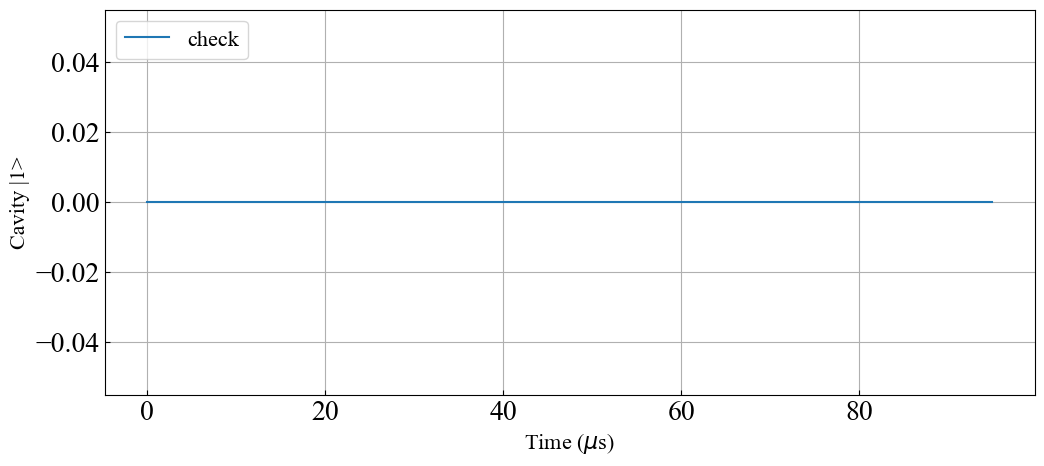

In [422]:
c_photon = tensor(qeye(device['N_q']), qeye(device['N_m']), qeye(device['N_s']), ket("1",device['N_s'])*bra("1",device['N_s']))
result = []
for ii in output.states:
    result.append(expect(c_photon, ii))
print(max(result))

fig, ax = plt.subplots(1, 1, figsize=(12,5))

ax.plot(tlist, result, label='check')
ax.set_xlabel('Time ($\mu$s)')
ax.set_ylabel('Cavity |1>')
ax.tick_params(labelsize=20)
# plt.axvline(Tt)
plt.legend(fontsize=16, loc=2)
plt.grid()

# Package gate

In [465]:
def gate2pulse(gate_name, psi0, t0, device, gate_length):

    # gate name iMj
    # 1,2,3,4,5,6 are qubit gates, 1, -1j, -1, 1j corresponds to X, Y, -X, -Y
    # gate sequence: Si-M1, M1-Qf, Qf-Qe, Qubit gate, Qe-Qf, Qf- M1, M1-Si, sync between all
    driving_param = {}
    driving_param['A_ge'] = 1/ge_length/2*np.pi/2 *0
    driving_param['A_ge_y'] = 1/ge_length/2*np.pi/2 *0
    driving_param['A_ef'] = 1/ef_length/2*np.pi *0 
    driving_param['A_f0g1'] = 1/f0g1_length/2*np.pi/np.sqrt(2) *0 
    driving_param['A_m1s1'] = 1/m1s1_length/2*np.pi *0
    driving_param['A_m1s2'] = 1/m1s2_length/2*np.pi *0

    psinow = psi0
    tnow = t0
    # print(gate_name)

    if gate_name[1] != 'F':  # not the first gate
        if gate_name[2] == '1':
            # print(gate_name[2])
            driving_param['A_m1s1'] = 1/gate_length['m1s1_length']/2*np.pi
            tlist = np.linspace(0, gate_length['m1s1_length'], 501)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()
            driving_param['A_m1s1'] = 0
            tlist = np.linspace(0, gate_length['sync'], 101)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()
        else:
            # print(gate_name[2])
            driving_param['A_m1s2'] = 1/gate_length['m1s2_length']/2*np.pi
            tlist = np.linspace(0, gate_length['m1s2_length'], 501)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()
            driving_param['A_m1s2'] = 0
            tlist = np.linspace(0, gate_length['sync'], 101)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()

        driving_param['A_f0g1'] = 1/gate_length['f0g1_length']/2*np.pi/np.sqrt(2)
        tlist = np.linspace(0, gate_length['f0g1_length'], 501)
        psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
        psinow = psinow.unit()
        driving_param['A_f0g1'] = 0
        tlist = np.linspace(0, gate_length['sync'], 101)
        psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
        psinow = psinow.unit()
        


        driving_param['A_ef'] = 1/gate_length['ef_length']/2*np.pi
        tlist = np.linspace(0, gate_length['ef_length'], 501)
        psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
        psinow = psinow.unit()
        driving_param['A_ef'] = 0
        tlist = np.linspace(0, gate_length['sync'], 101)
        psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
        psinow = psinow.unit()

        #### qubit gate #######        
        if gate_name[0] == '1':
            driving_param['A_ge'] = 1/ge_length/2*np.pi /2 
            tlist = np.linspace(0, gate_length['ge_length'], 501)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()
            tlist = np.linspace(0, gate_length['ge_length'], 501)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()
        if gate_name[0] == '2':
            driving_param['A_ge_y'] = 1/ge_length/2*np.pi /2 
            tlist = np.linspace(0, gate_length['ge_length'], 501)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()
            tlist = np.linspace(0, gate_length['ge_length'], 501)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()
        if gate_name[0] == '3':
            driving_param['A_ge'] = 1/ge_length/2*np.pi /2 
            tlist = np.linspace(0, gate_length['ge_length'], 501)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()
        if gate_name[0] == '4':
            driving_param['A_ge_y'] = 1/ge_length/2*np.pi /2 
            tlist = np.linspace(0, gate_length['ge_length'], 501)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()
        if gate_name[0] == '5':
            driving_param['A_ge'] = -1/ge_length/2*np.pi /2 
            tlist = np.linspace(0, gate_length['ge_length'], 501)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()
        if gate_name[0] == '6':
            driving_param['A_ge_y'] = -1/ge_length/2*np.pi /2 
            tlist = np.linspace(0, gate_length['ge_length'], 501)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()


        driving_param['A_ge'] = 0
        driving_param['A_ge_y'] = 0
        tlist = np.linspace(0, gate_length['sync'], 101)
        psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
        psinow = psinow.unit()

        ######################
        driving_param['A_ef'] = -1/gate_length['ef_length']/2*np.pi
        tlist = np.linspace(0, gate_length['ef_length'], 501)
        psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
        psinow = psinow.unit()
        driving_param['A_ef'] = 0
        tlist = np.linspace(0, gate_length['sync'], 101)
        psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
        psinow = psinow.unit()

        driving_param['A_f0g1'] = -1/gate_length['f0g1_length']/2*np.pi/np.sqrt(2)
        tlist = np.linspace(0, gate_length['f0g1_length'], 501)
        psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
        psinow = psinow.unit()
        driving_param['A_f0g1'] = 0
        tlist = np.linspace(0, gate_length['sync'], 101)
        psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
        psinow = psinow.unit()

        if gate_name[2] == '1':
            # print(gate_name[2])
            driving_param['A_m1s1'] = -1/gate_length['m1s1_length']/2*np.pi
            tlist = np.linspace(0, gate_length['m1s1_length'], 501)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()
            driving_param['A_m1s1'] = 0
            tlist = np.linspace(0, gate_length['sync'], 101)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()
        else:
            # print(gate_name[2])
            driving_param['A_m1s2'] = -1/gate_length['m1s2_length']/2*np.pi
            tlist = np.linspace(0, gate_length['m1s2_length'], 501)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()
            driving_param['A_m1s2'] = 0
            tlist = np.linspace(0, gate_length['sync'], 101)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()

    if gate_name[1] == 'F':
        #### qubit gate #######        
        if gate_name[0] == '1':
            driving_param['A_ge'] = 1/ge_length/2*np.pi /2 
            tlist = np.linspace(0, gate_length['ge_length'], 501)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()
            tlist = np.linspace(0, gate_length['ge_length'], 501)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()
        if gate_name[0] == '2':
            driving_param['A_ge_y'] = 1/ge_length/2*np.pi /2 
            tlist = np.linspace(0, gate_length['ge_length'], 501)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()
            tlist = np.linspace(0, gate_length['ge_length'], 501)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()
        if gate_name[0] == '3':
            driving_param['A_ge'] = 1/ge_length/2*np.pi /2 
            tlist = np.linspace(0, gate_length['ge_length'], 501)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()
        if gate_name[0] == '4':
            driving_param['A_ge_y'] = 1/ge_length/2*np.pi /2 
            tlist = np.linspace(0, gate_length['ge_length'], 501)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()
        if gate_name[0] == '5':
            driving_param['A_ge'] = -1/ge_length/2*np.pi /2 
            tlist = np.linspace(0, gate_length['ge_length'], 501)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()
        if gate_name[0] == '6':
            driving_param['A_ge_y'] = -1/ge_length/2*np.pi /2 
            tlist = np.linspace(0, gate_length['ge_length'], 501)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()


        driving_param['A_ge'] = 0
        driving_param['A_ge_y'] = 0
        tlist = np.linspace(0, gate_length['sync'], 101)
        psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
        psinow = psinow.unit()

        ######################
        driving_param['A_ef'] = -1/gate_length['ef_length']/2*np.pi
        tlist = np.linspace(0, gate_length['ef_length'], 501)
        psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
        psinow = psinow.unit()
        driving_param['A_ef'] = 0
        tlist = np.linspace(0, gate_length['sync'], 101)
        psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
        psinow = psinow.unit()

        driving_param['A_f0g1'] = -1/gate_length['f0g1_length']/2*np.pi/np.sqrt(2)
        tlist = np.linspace(0, gate_length['f0g1_length'], 501)
        psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
        psinow = psinow.unit()
        driving_param['A_f0g1'] = 0
        tlist = np.linspace(0, gate_length['sync'], 101)
        psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
        psinow = psinow.unit()

        if gate_name[2] == '1':
            # print(gate_name[2])
            driving_param['A_m1s1'] = -1/gate_length['m1s1_length']/2*np.pi
            tlist = np.linspace(0, gate_length['m1s1_length'], 501)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()
            driving_param['A_m1s1'] = 0
            tlist = np.linspace(0, gate_length['sync'], 101)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()
        else:
            # print(gate_name[2])
            driving_param['A_m1s2'] = -1/gate_length['m1s2_length']/2*np.pi
            tlist = np.linspace(0, gate_length['m1s2_length'], 501)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()
            driving_param['A_m1s2'] = 0
            tlist = np.linspace(0, gate_length['sync'], 101)
            psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
            psinow = psinow.unit()
    psi_end = psinow
    t_end = tnow

    return psi_end, t_end

In [453]:
def readout(psi0, t0, device, gate_length):

    # readout state population, provide results of two qobjs
    driving_param = {}
    driving_param['A_ge'] = 1/ge_length/2*np.pi   /2  *0
    driving_param['A_ge_y'] = 1/ge_length/2*np.pi   /2  *0
    driving_param['A_ef'] = 1/ef_length/2*np.pi *0 
    driving_param['A_f0g1'] = 1/f0g1_length/2*np.pi/np.sqrt(2) *0 
    driving_param['A_m1s1'] = 1/m1s1_length/2*np.pi *0
    driving_param['A_m1s2'] = 1/m1s2_length/2*np.pi *0

  
    psinow = psi0
    tnow = t0
    
    #  readout the first one
    driving_param['A_m1s1'] = 1/gate_length['m1s1_length']/2*np.pi
    tlist = np.linspace(0, gate_length['m1s1_length'], 501)
    psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
    psinow = psinow.unit()
    driving_param['A_m1s1'] = 0
    tlist = np.linspace(0, gate_length['sync'], 101)
    psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
    psinow = psinow.unit()

    driving_param['A_f0g1'] = 1/gate_length['f0g1_length']/2*np.pi/np.sqrt(2)
    tlist = np.linspace(0, gate_length['f0g1_length'], 501)
    psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
    psinow = psinow.unit()
    driving_param['A_f0g1'] = 0
    tlist = np.linspace(0, gate_length['sync'], 101)
    psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
    psinow = psinow.unit()
    


    driving_param['A_ef'] = 1/gate_length['ef_length']/2*np.pi
    tlist = np.linspace(0, gate_length['ef_length'], 501)
    psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
    psinow = psinow.unit()
    driving_param['A_ef'] = 0
    tlist = np.linspace(0, gate_length['sync'], 101)
    psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
    psinow = psinow.unit()

    psi1 = psinow


    


    #  readout the second one
    psinow = psi0
    tnow = t0

    driving_param['A_m1s2'] = 1/gate_length['m1s2_length']/2*np.pi
    tlist = np.linspace(0, gate_length['m1s2_length'], 501)
    psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
    psinow = psinow.unit()
    driving_param['A_m1s2'] = 0
    tlist = np.linspace(0, gate_length['sync'], 101)
    psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
    psinow = psinow.unit()

    driving_param['A_f0g1'] = 1/gate_length['f0g1_length']/2*np.pi/np.sqrt(2)
    tlist = np.linspace(0, gate_length['f0g1_length'], 501)
    psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
    psinow = psinow.unit()
    driving_param['A_f0g1'] = 0
    tlist = np.linspace(0, gate_length['sync'], 101)
    psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
    psinow = psinow.unit()
    


    driving_param['A_ef'] = 1/gate_length['ef_length']/2*np.pi
    tlist = np.linspace(0, gate_length['ef_length'], 501)
    psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
    psinow = psinow.unit()
    driving_param['A_ef'] = 0
    tlist = np.linspace(0, gate_length['sync'], 101)
    psinow, tnow, outputnow = QMSS_system(tlist, tnow, psinow, driving_param, device)
    psinow = psinow.unit()

    psi2 = psinow


   


    return psi1, psi2

# generate rb sequence

In [185]:
"""
Single qubit RB sequence generator
Gate set = {I, +-X/2, +-Y/2, +-Z/2, X, Y, Z}
"""
## generate sequences of random pulses
## 1:Z,   2:X, 3:Y
## 4:Z/2, 5:X/2, 6:Y/2
## 7:-Z/2, 8:-X/2, 9:-Y/2
## 0:I
## Calculate inverse rotation
matrix_ref = {}
# Z, X, Y, -Z, -X, -Y
matrix_ref['0'] = np.matrix([[1, 0, 0, 0, 0, 0],
                                [0, 1, 0, 0, 0, 0],
                                [0, 0, 1, 0, 0, 0],
                                [0, 0, 0, 1, 0, 0],
                                [0, 0, 0, 0, 1, 0],
                                [0, 0, 0, 0, 0, 1]])
matrix_ref['1'] = np.matrix([[0, 0, 0, 1, 0, 0],
                                [0, 1, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 1],
                                [1, 0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 1, 0],
                                [0, 0, 1, 0, 0, 0]])
matrix_ref['2'] = np.matrix([[0, 0, 0, 1, 0, 0],
                                [0, 0, 0, 0, 1, 0],
                                [0, 0, 1, 0, 0, 0],
                                [1, 0, 0, 0, 0, 0],
                                [0, 1, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 1]])
matrix_ref['3'] = np.matrix([[0, 0, 1, 0, 0, 0],
                                [0, 1, 0, 0, 0, 0],
                                [0, 0, 0, 1, 0, 0],
                                [0, 0, 0, 0, 0, 1],
                                [0, 0, 0, 0, 1, 0],
                                [1, 0, 0, 0, 0, 0]])
matrix_ref['4'] = np.matrix([[0, 0, 0, 0, 1, 0],
                                [1, 0, 0, 0, 0, 0],
                                [0, 0, 1, 0, 0, 0],
                                [0, 1, 0, 0, 0, 0],
                                [0, 0, 0, 1, 0, 0],
                                [0, 0, 0, 0, 0, 1]])
matrix_ref['5'] = np.matrix([[0, 0, 0, 0, 0, 1],
                                [0, 1, 0, 0, 0, 0],
                                [1, 0, 0, 0, 0, 0],
                                [0, 0, 1, 0, 0, 0],
                                [0, 0, 0, 0, 1, 0],
                                [0, 0, 0, 1, 0, 0]])
matrix_ref['6'] = np.matrix([[0, 1, 0, 0, 0, 0],
                                [0, 0, 0, 1, 0, 0],
                                [0, 0, 1, 0, 0, 0],
                                [0, 0, 0, 0, 1, 0],
                                [1, 0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 1]])

def no2gate(no):
    g = 'I'
    if no==1:
        g = 'X'
    elif no==2:
        g = 'Y'
    elif no==3:
        g = 'X/2'
    elif no==4:
        g = 'Y/2'
    elif no==5:
        g = '-X/2'
    elif no==6:
        g = '-Y/2'  

    return g

def gate2no(g):
    no = 0
    if g=='X':
        no = 1
    elif g=='Y':
        no = 2
    elif g=='X/2':
        no = 3
    elif g=='Y/2':
        no = 4
    elif g=='-X/2':
        no = 5
    elif g=='-Y/2':
        no = 6

    return no

def generate_sequence(rb_depth, iRB_gate_no=-1, debug=False, matrix_ref=matrix_ref):
    gate_list = []
    for ii in range(rb_depth):
        gate_list.append(random.randint(1, 6))   # from 1 to 6
        if iRB_gate_no > -1:   # performing iRB
            gate_list.append(iRB_gate_no)

    a0 = np.matrix([[1], [0], [0], [0], [0], [0]]) # initial state
    anow = a0
    for i in gate_list:
        anow = np.dot(matrix_ref[str(i)], anow)
    anow1 = np.matrix.tolist(anow.T)[0]
    max_index = anow1.index(max(anow1))
    # inverse of the rotation
    inverse_gate_symbol = ['-Y/2', 'X/2', 'X', 'Y/2', '-X/2']
    if max_index == 0:
        pass
    else:
        gate_list.append(gate2no(inverse_gate_symbol[max_index-1]))
    if debug:
        print(gate_list)
        print(max_index)
    return gate_list

def random_pick_from_lists(a):
    # Initialize index pointers for each sublist
    indices = [0] * len(a)
    # Total number of elements to pick
    total_elements = sum(len(sublist) for sublist in a)
    # Output list
    b = []
    # List to track which sublist each element was picked from
    origins = []

    # Continue until all elements are picked
    pick_no = 0
    while len(b) < total_elements:
        # Find all sublists that have elements left to pick
        available = [i for i in range(len(a)) if indices[i] < len(a[i])]
        # Randomly select one of the available sublists

        chosen_list = random.choice(available)
        # chosen_list = pick_no % len(a)
        # Pick the element from the chosen sublist and append to b
        b.append(a[chosen_list][indices[chosen_list]])
        # Record the origin of the picked element
        origins.append(chosen_list)
        # Update the index pointer for the chosen sublist
        indices[chosen_list] += 1
        pick_no += 1

    return b, origins
def round_robin_pick(a):
    # Calculate the total number of elements
    total_elements = sum(len(lst) for lst in a)
    
    # Initialize indices for each list
    indices = [0] * len(a)
    
    # Output list
    b = []
    # List to track which sublist each element was picked from
    origins = []
    
    # Continue until all elements are picked
    pick_no = 0
    while len(b) < total_elements:
        # Find all sublists that have elements left to pick
        available = [i for i in range(len(a)) if indices[i] < len(a[i])]
        
        # Use round-robin approach to select the next list
        chosen_list = pick_no % len(a)
        
        # If the chosen list has elements left, pick the element
        if indices[chosen_list] < len(a[chosen_list]):
            # Pick the element from the chosen sublist and append to b
            b.append(a[chosen_list][indices[chosen_list]])
            # Record the origin of the picked element
            origins.append(chosen_list)
            # Update the index pointer for the chosen sublist
            indices[chosen_list] += 1
        
        pick_no += 1
    
    return b, origins
def find_unique_elements_and_positions(lst):
    unique_elements = []
    first_positions = {}
    last_positions = {}

    # Iterate over the list to find the first and last occurrence of each element
    for idx, elem in enumerate(lst):
        # Update the last position for every occurrence
        last_positions[elem] = idx
        # If the element is encountered for the first time, record its first position
        if elem not in first_positions:
            unique_elements.append(elem)
            first_positions[elem] = idx

    # Create lists of the positions in the order of unique elements
    first_pos_list = [first_positions[elem] for elem in unique_elements]
    last_pos_list = [last_positions[elem] for elem in unique_elements]

    return unique_elements, first_pos_list, last_pos_list

def RAM_rb(storage_id, depth_list):

    """
    Multimode RAM RB generator with VZ speicified
    Gate set = {+-X/2, +-Y/2, X, Y}
    storage_id: a list specifying the operation on storage i, eg [1,3,5] means operation on S1, S3,S5
    depth_list: a list specifying the individual rb depth on corresponding storage specified in storage_id list

    depth_list and storage_id should have the same length

    phase_overhead: a 7*7 matrix showing f0g1+[M1S1, ..., M1S7] pi swap's phase overhead to [S1, ..., S7] (time independent part). 
    phase_overhead[i][j] is M1-S(j+1) swap's+f0g1 phase overhead on M1-S(i+1) (only half of it, a V gate is 2*phase_overhead)

    phase_freq: a 1*7 list showing [M1S1, ..., M1S7]'s time-dependent phase accumulation rate during idle sessions.
    gate_t_length: a dictionary ,all in cycles
        'pi_ge_length': in cycles
        'hpi_ge_length': in cycles
        'pi_ef_length': in cycles
        'f0g1_length': in cycles
        'M1S1_length': in cycles
        'M1S2_length': in cycles
        'M1S3_length': in cycles
        'M1S4_length': in cycles
        'M1S5_length': in cycles
        'M1S6_length': in cycles
        'M1S7_length': in cycles

    Each storage operation has two parts:
    if it is not the initial gate, extract information, gates on qubit, then store information
    The initial gate only perform gate on qubit, then store information
    The last gate only extract information, gate on qubit and check |g> population

    gate_list: a list of strings, each string is gate_id+'F/L/M'+storage_id. 'F': first gate on the storage, 'L': last gate on the storage, 'M': any other gate between F and L
    vz_phase_list: virtual z phase (in degree)

    """


    # generate random gate_list for individual storage 
    individual_storage_gate = []
    for ii in range(len(depth_list)):
        individual_storage_gate.append(generate_sequence(depth_list[ii]))
        # invi
    stacked_gate, origins = round_robin_pick(individual_storage_gate)
    for ii in range(len(origins)):
        # convert origins to storage mode id
        origins[ii] = storage_id[origins[ii]]

    # check first or last element position
    unique_elements, first_pos_list, last_pos_list = find_unique_elements_and_positions(origins)


    # convert origins+stacked gate to gate_list form

    #cycles2us = self.cycles2us(1)   # coefficient
    # print('cycles2us ', cycles2us)

    gate_list = []
    for ii in range(len(stacked_gate)):
        gate_name = str(stacked_gate[ii])
        gate_symbol = 'M'
        vz = 0
        
        if ii in first_pos_list: 
            gate_symbol = 'F'
        if ii in last_pos_list: gate_symbol = 'L'

        gate_name = gate_name+gate_symbol+str(origins[ii])

        gate_list.append(gate_name)

    
    return gate_list

In [186]:
aa = RAM_rb([1,2], [20,20])

# device definition and pulsing gate

## no decoherence

In [477]:
device = {}
gate_length = {}

storage_id = [1,2]


device['N_q'], device['N_m'], device['N_s'] = 4, 3, 3
device['zz_qm'], device['zz_ms1'], device['zz_ms2'], device['zz_s12'] = -0.285*2*np.pi, -0.00336*2*np.pi, -0.001838*2*np.pi, -0.0002695*np.pi*2
device['T1_q'],device['T1_m'],device['T1_s1'],device['T1_s2'] = 490*0, 210*0, 358*0, 1254*0   # not used
device['T2_q'],device['T2_m'],device['T2_s1'],device['T2_s2'] = 259, 75.5, 204, 460  # not used

ge_length = 0.035*4
ef_length = 0.035*4
sync = 0.01
f0g1_length = 0.615287 + 0.005*6
m1s1_length = 0.919488 + 0.005*6
m1s2_length = 1.055448 + 0.005*6

gate_length['ge_length'] = ge_length
gate_length['ef_length'] = ef_length
gate_length['sync'] = sync
gate_length['f0g1_length'] = f0g1_length
gate_length['m1s1_length'] = m1s1_length
gate_length['m1s2_length'] = m1s2_length

ground_state = tensor(ket("0",device['N_q'])*bra("0",device['N_q']), qeye(device['N_m']), qeye(device['N_s']), qeye(device['N_s']))

psi0 = tensor(ket("0", device['N_q']), ket("0", device['N_m']), ket("0", device['N_s']), ket("0", device['N_s']))
psi0 = psi0.unit()

psi_now = psi0
tnow = 0

depth_sweep = np.arange(1,50,5)
# depth_sweep = [20]
random_seq = 10

fidelity_list1 = []
err_list1 = []

fidelity_list2 = []
err_list2 = []

for dep in depth_sweep:
    avg_readout1 = []
    avg_readout2 = []
    print('checking depth: ',dep)
    for ii in range(random_seq):

        depth_list = [dep,dep]
        psi_now = tensor(ket("0", device['N_q']), ket("0", device['N_m']), ket("0", device['N_s']), ket("0", device['N_s']))
        tnow = 0

        toapply = RAM_rb(storage_id, depth_list)
        for gate_name in toapply:
            # print('Running gate: ',gate_name)
            psi_now, tnow = gate2pulse(gate_name, psi_now, tnow, device, gate_length)

            # # for debug
            # psi1, psi2 = readout(psi_now, tnow, device, gate_length)
            # print(expect(ket2dm(psi1), ground_state), expect(ket2dm(psi2), ground_state))

        # perform readout
        psi1, psi2 = readout(psi_now, tnow, device, gate_length)

        fid = expect(ket2dm(psi1), ground_state)
        avg_readout1.append(fid)
        fid = expect(ket2dm(psi2), ground_state)
        avg_readout2.append(fid)

    std_dev = np.std(avg_readout1, ddof=1)
    err_list1.append(std_dev / np.sqrt(len(avg_readout1)))
    fidelity_list1.append(np.average(avg_readout1))

    std_dev = np.std(avg_readout2, ddof=1)
    err_list2.append(std_dev / np.sqrt(len(avg_readout2)))
    fidelity_list2.append(np.average(avg_readout2))

checking depth:  1
checking depth:  6
checking depth:  11
checking depth:  16
checking depth:  21
checking depth:  26
checking depth:  31
checking depth:  36
checking depth:  41
checking depth:  46


In [475]:
fidelity_list2

[0.9970182884384778]

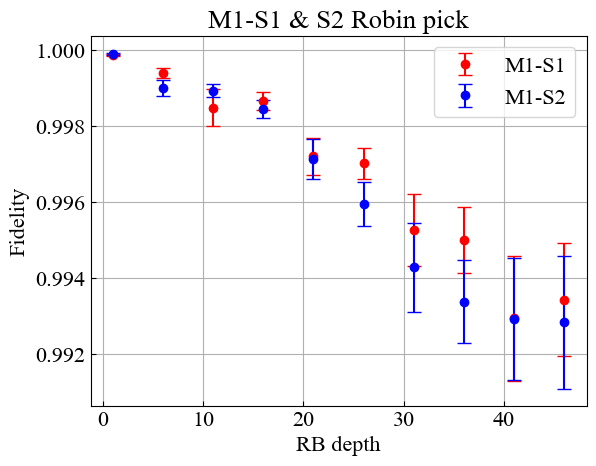

In [483]:
plt.errorbar(depth_sweep, fidelity_list1, yerr= err_list1,fmt = 'o', capsize=5, color='r', label='M1-S1')
plt.errorbar(depth_sweep, fidelity_list2, yerr= err_list2,fmt = 'o', capsize=5, color='b', label='M1-S2')

plt.xlabel('RB depth')
plt.ylabel('Fidelity')
plt.title(f'M1-S1 & S2 Robin pick')
plt.legend()
plt.grid()
plt.show()

In [486]:
def expfunc(x, *p):
    y0, yscale, x0, decay = p
    return y0 + yscale*np.exp(-(x-x0)/decay)

def fitexp(xdata, ydata, fitparams=None):
    if fitparams is None: fitparams = [None]*4
    if fitparams[0] is None: fitparams[0] = ydata[-1]
    if fitparams[1] is None: fitparams[1] = ydata[0]-ydata[-1]
    if fitparams[2] is None: fitparams[2] = xdata[0]
    if fitparams[3] is None: fitparams[3] = (xdata[-1]-xdata[0])/5
    pOpt = fitparams
    pCov = np.full(shape=(len(fitparams), len(fitparams)), fill_value=np.inf)
    try:
        pOpt, pCov = optimize.curve_fit(expfunc, xdata, ydata, p0=fitparams, maxfev=200000)
        # return pOpt, pCov
    except RuntimeError: 
        print('Warning: fit failed!')
        # return 0, 0
    return pOpt, pCov

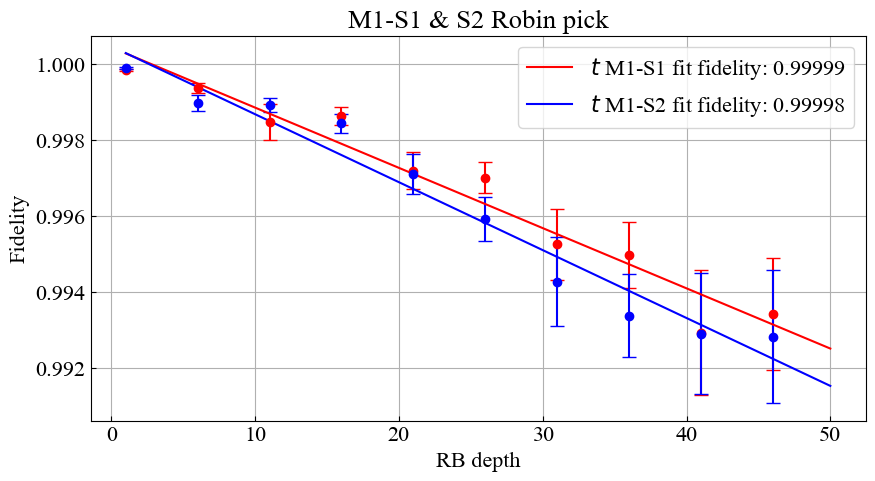

In [491]:

xx = np.linspace(1,50,100)


plt.figure(figsize=(10,5))
plt.subplot(111,  ylabel="Fidelity")

#for idx, prepulse_label in enumerate(prepulse_list_labels):

plt.errorbar(depth_sweep, fidelity_list1, yerr= err_list1,fmt = 'o', capsize=5, color='r')
plt.errorbar(depth_sweep, fidelity_list2, yerr= err_list2,fmt = 'o', capsize=5, color='b')

# fitting 
xpts = depth_sweep
ypts = fidelity_list1
fit1,err1 = fitexp(xpts, ypts, fitparams=None)

alpha1 = np.exp(-1/fit1[3])
r1 = 1-alpha1-(1-alpha1)/2
fidelity1 = 1-r1

p = fit1 #data['fit_avgi']
pCov = err1 #data['fit_err_avgi']
captionStr1 = f'$t$ M1-S1 fit fidelity: {fidelity1:.5f}'
plt.plot(xx, expfunc(xx, *fit1), label=captionStr1, color='r')

xpts = depth_sweep
ypts = fidelity_list2
fit2,err2 = fitexp(xpts, ypts, fitparams=None)

alpha2 = np.exp(-1/fit2[3])
r2 = 1-alpha2-(1-alpha2)/2
fidelity2 = 1-r2

p = fit2 #data['fit_avgi']
pCov = err2 #data['fit_err_avgi']
captionStr2 = f'$t$ M1-S2 fit fidelity: {fidelity2:.5f}'
plt.plot(xx, expfunc(xx, *fit2), label=captionStr2, color='b')




plt.xlabel('RB depth')
plt.ylabel('Fidelity')
plt.title(f'M1-S1 & S2 Robin pick')
plt.legend()
plt.grid()
plt.show()

In [490]:
1-0.008/46

0.9998260869565218

## with T1 decay

In [492]:
device = {}
gate_length = {}

storage_id = [1,2]


device['N_q'], device['N_m'], device['N_s'] = 4, 3, 3
device['zz_qm'], device['zz_ms1'], device['zz_ms2'], device['zz_s12'] = -0.285*2*np.pi, -0.00336*2*np.pi, -0.001838*2*np.pi, -0.0002695*np.pi*2
device['T1_q'],device['T1_m'],device['T1_s1'],device['T1_s2'] = 490, 210, 358, 1254   # not used
device['T2_q'],device['T2_m'],device['T2_s1'],device['T2_s2'] = 259, 75.5, 204, 460  # not used

ge_length = 0.035*4
ef_length = 0.035*4
sync = 0.01
f0g1_length = 0.615287 + 0.005*6
m1s1_length = 0.919488 + 0.005*6
m1s2_length = 1.055448 + 0.005*6

gate_length['ge_length'] = ge_length
gate_length['ef_length'] = ef_length
gate_length['sync'] = sync
gate_length['f0g1_length'] = f0g1_length
gate_length['m1s1_length'] = m1s1_length
gate_length['m1s2_length'] = m1s2_length

ground_state = tensor(ket("0",device['N_q'])*bra("0",device['N_q']), qeye(device['N_m']), qeye(device['N_s']), qeye(device['N_s']))

psi0 = tensor(ket("0", device['N_q']), ket("0", device['N_m']), ket("0", device['N_s']), ket("0", device['N_s']))
psi0 = psi0.unit()

psi_now = psi0
tnow = 0

depth_sweep = np.arange(1,50,5)
# depth_sweep = [20]
random_seq = 10

fidelity_list1 = []
err_list1 = []

fidelity_list2 = []
err_list2 = []

for dep in depth_sweep:
    avg_readout1 = []
    avg_readout2 = []
    print('checking depth: ',dep)
    for ii in range(random_seq):

        depth_list = [dep,dep]
        psi_now = tensor(ket("0", device['N_q']), ket("0", device['N_m']), ket("0", device['N_s']), ket("0", device['N_s']))
        tnow = 0

        toapply = RAM_rb(storage_id, depth_list)
        for gate_name in toapply:
            # print('Running gate: ',gate_name)
            psi_now, tnow = gate2pulse(gate_name, psi_now, tnow, device, gate_length)

            # # for debug
            # psi1, psi2 = readout(psi_now, tnow, device, gate_length)
            # print(expect(ket2dm(psi1), ground_state), expect(ket2dm(psi2), ground_state))

        # perform readout
        psi1, psi2 = readout(psi_now, tnow, device, gate_length)

        fid = expect((psi1), ground_state)
        avg_readout1.append(fid)
        fid = expect((psi2), ground_state)
        avg_readout2.append(fid)

    std_dev = np.std(avg_readout1, ddof=1)
    err_list1.append(std_dev / np.sqrt(len(avg_readout1)))
    fidelity_list1.append(np.average(avg_readout1))

    std_dev = np.std(avg_readout2, ddof=1)
    err_list2.append(std_dev / np.sqrt(len(avg_readout2)))
    fidelity_list2.append(np.average(avg_readout2))

checking depth:  1
checking depth:  6
checking depth:  11
checking depth:  16
checking depth:  21
checking depth:  26
checking depth:  31
checking depth:  36
checking depth:  41
checking depth:  46


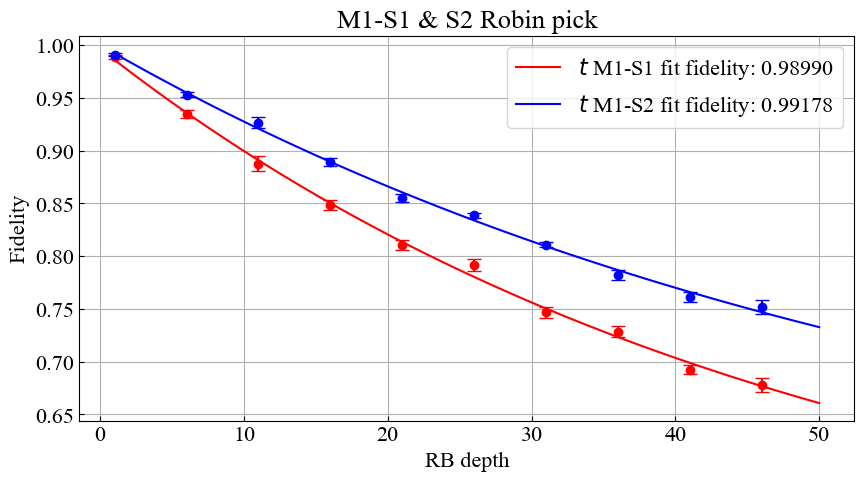

In [493]:

xx = np.linspace(1,50,100)


plt.figure(figsize=(10,5))
plt.subplot(111,  ylabel="Fidelity")

#for idx, prepulse_label in enumerate(prepulse_list_labels):

plt.errorbar(depth_sweep, fidelity_list1, yerr= err_list1,fmt = 'o', capsize=5, color='r')
plt.errorbar(depth_sweep, fidelity_list2, yerr= err_list2,fmt = 'o', capsize=5, color='b')

# fitting 
xpts = depth_sweep
ypts = fidelity_list1
fit1,err1 = fitexp(xpts, ypts, fitparams=None)

alpha1 = np.exp(-1/fit1[3])
r1 = 1-alpha1-(1-alpha1)/2
fidelity1 = 1-r1

p = fit1 #data['fit_avgi']
pCov = err1 #data['fit_err_avgi']
captionStr1 = f'$t$ M1-S1 fit fidelity: {fidelity1:.5f}'
plt.plot(xx, expfunc(xx, *fit1), label=captionStr1, color='r')

xpts = depth_sweep
ypts = fidelity_list2
fit2,err2 = fitexp(xpts, ypts, fitparams=None)

alpha2 = np.exp(-1/fit2[3])
r2 = 1-alpha2-(1-alpha2)/2
fidelity2 = 1-r2

p = fit2 #data['fit_avgi']
pCov = err2 #data['fit_err_avgi']
captionStr2 = f'$t$ M1-S2 fit fidelity: {fidelity2:.5f}'
plt.plot(xx, expfunc(xx, *fit2), label=captionStr2, color='b')




plt.xlabel('RB depth')
plt.ylabel('Fidelity')
plt.title(f'M1-S1 & S2 Robin pick')
plt.legend()
plt.grid()
plt.show()